In [1]:
# the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import cv2
sys.path.insert(0, '../codes')
import video_handling
from utils.img_utils import rectify_img, compute_mse, compute_psnr, compute_ssim

/home/wesley.passos/miniconda3/envs/mosquitoes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
#make matplotlib figures appear inline in the notebook
#rather than in a new window.
%matplotlib inline
#sns.set()
# set default size of plots
plt.rcParams['figure.figsize'] = (12.0, 10.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#print OpenCV version
print ("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.4.3 


## Detecting keypoints and computing cam params

In [4]:
videos_path = '../data/dataset/2018-09-19/seq001'
video_name = 'calibration/DJI_0017.MOV'

video = os.path.join(videos_path, video_name)

In [5]:
vid = video_handling.videoObj(videopath=video)

# computing cam params using image taken at every 10 frames
# we use alpha equals 0, so that rectified image has the same size of original image
cam_params = vid.cam_params(alpha=0, every=10)

Detecting keypoints...


HBox(children=(IntProgress(value=0, max=940), HTML(value='')))


Number of pattern found:  34
computing cam params...
Done!


In [6]:
print('rms: {}\n'.format(cam_params['ret']))
print('camera matrix:\n {} \n'.format(cam_params['mtx']))
print('distortion coefficients:\n {}\n'.format(cam_params['dist']))
print('new camera matrix:\n {} \n'.format(cam_params['newcameramtx']))
print('roi:\n {} '.format(cam_params['roi']))

rms: 0.9065833709389759

camera matrix:
 [[2.66731673e+03 0.00000000e+00 1.79097460e+03]
 [0.00000000e+00 2.65610826e+03 1.11752551e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

distortion coefficients:
 [[-0.02137046  0.08708288  0.00098347 -0.01450101 -0.32126123]]

new camera matrix:
 [[2.72082178e+03 0.00000000e+00 1.74408334e+03]
 [0.00000000e+00 2.74734229e+03 1.11893756e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] 

roi:
 (0, 0, 3840, 2160) 


## Testing calibration

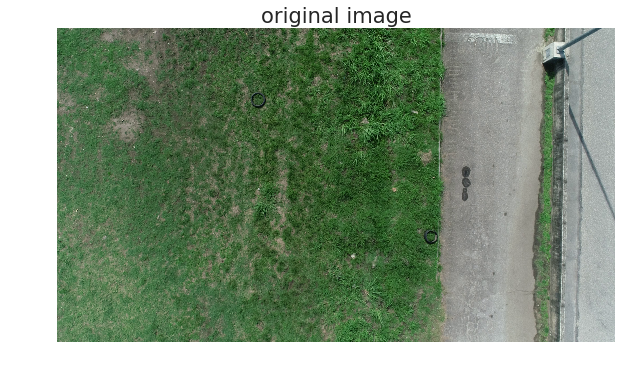

image size:  (2160, 3840, 3)


In [7]:
#extract frame
video_teste = 'missions/DJI_0018.MOV'
video_teste = os.path.join(videos_path, video_teste)
video_teste = video_handling.videoObj(videopath=video_teste)

ret, img, img_size = video_teste.get_frame(0)

#displaying image
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('original image')
plt.show()
print('image size: ', img.shape)

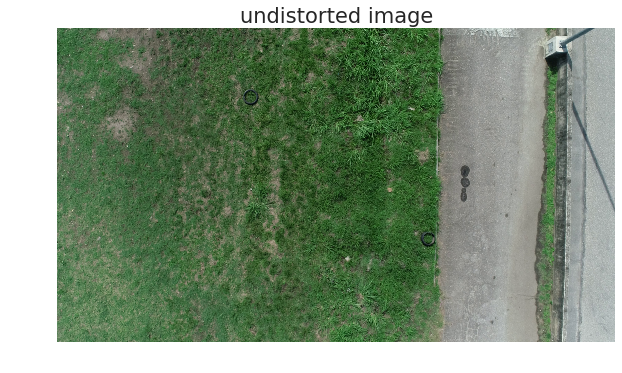

image size:  (2160, 3840, 3)


In [8]:
#undistort
dst = rectify_img(img, cam_params)

#displaying image
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('undistorted image')
plt.show()
print('image size: ', dst.shape)

### computing SSIM and MSE between images...

In [9]:
MSE = compute_mse(img, dst)
PSNR = compute_psnr(img, dst)
SSIM = compute_ssim(img, dst, multichannel=True)

print('MSE: {:.2f}'.format(MSE))
print('PSNR: {:.2f}'.format(PSNR))
print('SSIM: {:.2f}'.format(SSIM))

/home/wesley.passos/miniconda3/envs/mosquitoes/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


MSE: 654.82
PSNR: 19.97
SSIM: 0.31


### blending original and undistorted images...

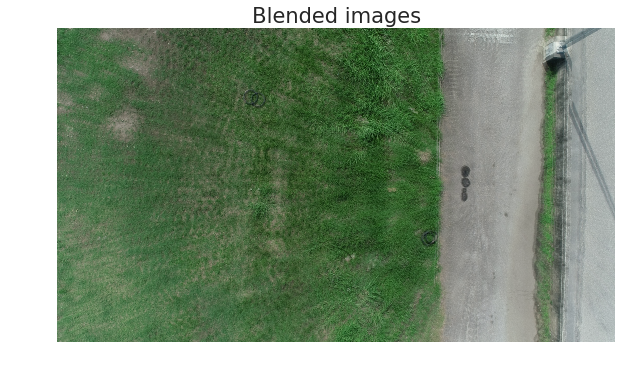

In [10]:
alpha = 0.5
beta = (1.0 - alpha)
blend = np.uint8(alpha*(img)+beta*(dst))

plt.imshow(cv2.cvtColor(blend,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Blended images')
plt.show()